tides and winds


In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import glob
import csv
import pandas as pd
from dateutil import tz
import seaborn as sns

from salishsea_tools import viz_tools, grid_tools
from salishsea_tools import tidetools, places
import matplotlib.dates as md

%matplotlib inline

In [2]:
sns.set_palette('gray')
sns.set_style('ticks')
sns.set_color_codes
start=datetime.datetime(2015,2,6)
end=datetime.datetime(2015,8,4)
times= [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

In [3]:
def list_wind_files(
    to, tf,
    wind_dir='/results/forcing/atmospheric/GEM2.5/operational/'
):
    """List operational wind files in date range [to, tf]

    :arg to: beginning of date range
    :type to: datetime object

    :arg tf: end of date range
    :type tf: datetime object

    :arg wind_dir: directory were wind files are stored
    :type wind_dir: str

    :returns: filesOP, a list of files in date range
    """
    sstr = to.strftime('ops_y%Ym%md%d.nc')
    estr = tf.strftime('ops_y%Ym%md%d.nc')
    files = glob.glob(os.path.join(wind_dir, 'ops_*.nc'))
    filesOP = []
    for filename in files:
        if os.path.basename(filename) >= sstr:
            if os.path.basename(filename) <= estr:
                if not filename.endswith('orig.nc'):
                    filesOP.append(filename)
        filesOP.sort(key=os.path.basename)
    filesOP.sort(key=os.path.basename)
    return filesOP

In [4]:
def compile_winds(j, i, files):
    """
    Compile a time series of operational atmospheric products stored in files
    at grid point j, i. First 24 hours of each file is used

    :arg j: the y-index of the grid point
    :type j: non-negative integer

    :arg i: the x-index of the grid point
    :type i: non-negative interger

    :arg files: list of atmospheric operational files
    :type files: list

    :returns: wind, direc, t, pr, tem, sol, the, qr, pre, all arrays
    wind speed, diretion, time, pressure, temperature, solar radiation,
    humidity, precipitation.

    """
    wind = []
    direc = []
    t = []
    pr = []
    sol = []
    the = []
    pre = []
    tem = []
    qr = []
    for f in files:
        G = nc.Dataset(f)
        u = G.variables['u_wind'][0:24, j, i]
        v = G.variables['v_wind'][0:24, j, i]
        pr.append(G.variables['atmpres'][0:24, j, i])
        sol.append(G.variables['solar'][0:24, j, i])
        qr.append(G.variables['qair'][0:24, j, i])
        the.append(G.variables['therm_rad'][0:24, j, i])
        pre.append(G.variables['precip'][0:24, j, i])
        tem.append(G.variables['tair'][0:24, j, i])
        speed = np.sqrt(u**2 + v**2)
        wind.append(speed)

        d = np.arctan2(v, u)
        d = np.rad2deg(d + (d < 0)*2*np.pi)
        direc.append(d)

        ts = G.variables['time_counter']
        torig = datetime.datetime(1970, 1, 1)
        # there is no time_origin attriubte in OP files, so I hard coded torig
        for ind in np.arange(24):
            t.append(torig + datetime.timedelta(seconds=ts[ind]))
    numdays = len(files)
    wind = np.array(wind).reshape(numdays*24,)
    direc = np.array(direc, 'double').reshape(numdays*24,)
    t = np.array(t).reshape(numdays*24,)
    pr = np.array(pr).reshape(numdays*24,)
    tem = np.array(tem).reshape(numdays*24,)
    sol = np.array(sol).reshape(numdays*24,)
    the = np.array(the).reshape(numdays*24,)
    qr = np.array(qr).reshape(numdays*24,)
    pre = np.array(pre).reshape(numdays*24,)

    return wind, direc, t, pr, tem, sol, the, qr, pre

In [5]:
def find_model_point(lon, lat, X, Y, tol_lon=0.016, tol_lat=0.011):
    """Finds a model grid point close to a specified latitude and longitude.
    Should be used for non-NEMO grids like the atmospheric forcing grid.

    :arg lon: The longitude we are trying to match.
    :type lon: float

    :arg lat: The latitude we are trying to match.
    :type lat: float

    :arg X: The model longitude grid.
    :type X: numpy array

    :arg Y: The model latitude grid.
    :type Y: numpy array

    :arg tol_lon: tolerance on grid spacing for longitude
    :type tol_lon: float

    :arg tol_lat: tolerance on grid spacing for latitude
    :type tol_lat: float

    :returns: j-index and i-index of the closest model grid point.
    """

    # Search for a grid point with longitude or latitude within
    # tolerance of measured location
    j, i = np.where(
        np.logical_and(
            (np.logical_and(X > lon - tol_lon, X < lon + tol_lon)),
            (np.logical_and(Y > lat - tol_lat, Y < lat + tol_lat))))

    if j.size > 1 or i.size > 1:
        raise ValueError(
            'Multiple model points found. tol_lon/tol_lat too big.'
        )
    elif not j or not i:
        raise ValueError(
            'No model point found. tol_lon/tol_lat too small or '
            'lon/lat outside of domain.'
        )
    return j, i

In [6]:
def load_tidal_predictions(filename):
    """Load tidal prediction from a file.

    :arg str filename: The path and file name of a CSV file that contains
                       ttide tidal predictions generated by
                       :kbd:`get_ttide_8.m`.

    :returns: ttide: Tidal predictions and mean sea level,
                     the mean component from the harmonic analysis.
    :rtype: :py:class:`pandas.DataFrame`
    """
    with open(filename) as f:
        mycsv = list(csv.reader(f))
        msl = float(mycsv[1][1])
    ttide = pd.read_csv(
        filename, skiprows=3, parse_dates=[0], date_parser=dateParserMeasured2)
    ttide = ttide.rename(
        columns={
            'Time_Local ': 'time',
            ' pred_8 ': 'pred_8',
            ' pred_all ': 'pred_all',
        })
    return ttide, msl


In [7]:
def dateParserMeasured2(s):
    """
    converts string in %d-%b-%Y %H:%M:%S format Pacific time to a
    datetime object UTC time.
    """
    PST = tz.tzoffset("PST", -28800)
    # convert the string to a datetime object
    unaware = datetime.datetime.strptime(s, "%d-%b-%Y %H:%M:%S ")
    # add in the local time zone (Canada/Pacific)
    aware = unaware.replace(tzinfo=PST)
    # convert to UTC
    return aware.astimezone(tz.tzutc())


# Load Mesh and Grid

In [8]:
SITES = places.PLACES

In [9]:
SITES

{'Boundary Bay': {'NEMO grid ji': (380, 335),
  'hist max sea lvl': 5.61,
  'lon lat': (-122.925, 49.0),
  'mean sea lvl': 3.09,
  'stn number': None,
  'wind grid ji': (129, 162),
  'ww3 grid ji': (222, 439)},
 'British Columbia': {'lon lat': (-123.6, 49.9)},
 'Calamity Point': {'NEMO grid ji': None,
  'lon lat': (-123.1276, 49.31262),
  'mean sea lvl': 3.09,
  'stn number': 7724,
  'ww3 grid ji': None},
 'Campbell River': {'NEMO grid ji': (747, 125),
  'hist max sea lvl': 5.35,
  'lon lat': (-125.24, 50.04),
  'mean sea lvl': 2.916,
  'stn number': 8074,
  'wind grid ji': (190, 102),
  'ww3 grid ji': (453, 109)},
 'Central node': {'NEMO grid ji': (424, 266),
  'ONC stationCode': 'SCVIP',
  'depth': 294,
  'lon lat': (-123.425825, 49.040066666)},
 'Cherry Point': {'NEMO grid ji': (343, 342),
  'hist max sea lvl': 5.846,
  'lon lat': (-122.766667, 48.866667),
  'mean sea lvl': 3.543,
  'stn number': 9449424,
  'wind grid ji': (122, 166),
  'ww3 grid ji': (193, 462)},
 'Cluster_1': {'NE

# Load Files

In [10]:
def plot_tides(ax, sdt, edt, times, ts_lines, tdir = '/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/tidal_predictions/',
               name = 'Campbell River'):
    fname = os.path.join(tdir, '{}_tidal_prediction_01-Jan-2015_01-Jan-2020.csv'.format(name))
    ttide, _ = load_tidal_predictions(fname)
    ax.plot(ttide.time, ttide.pred_all,'-k')
    ax.set_xlim([sdt,edt])
    ax.set_ylabel('Tidal height [m]')
    ax.set_ylim([-3,3])
    
    for t in ts_lines:
        ax.plot([times[t], times[t]], [-3,3], '--', color='gray')
    return ttide.time,ttide.pred_all

In [11]:
OP = nc.Dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2014m11d18.nc')
OPlon =OP.variables['nav_lon'][:]-360
OPlat = OP.variables['nav_lat'][:]


In [12]:
ts_lines=np.array([ 7, 14, 21, 28])

In [13]:
def plot_winds(ax, location, lons, lats, sdt, edt, times, ts_lines):
    
    #lon, lat = SITES['East node']['lon lat'] # Giorgio: change this lat lon to Iona outfall coordinates
    wind_files = list_wind_files(sdt, edt)
    j=190
    i=102 
    #find_model_point(lon,lat,lons,lats)
    wind, direc, t, pr, tem, sol, the, qr, pre = compile_winds(j,i,wind_files)
    
    datenum = md.date2num(t)
    us0 = wind*np.cos(np.deg2rad(direc))
    vs0 =  wind*np.sin(np.deg2rad(direc))
    us,vs=viz_tools.rotate_vel(us0,vs0,origin='map')
    
    q=ax.quiver(datenum, np.zeros(datenum.shape), us, vs,scale=8*10e0)
    
    qk = ax.quiverkey(q, 0.1, 0.1, 10, '10 m/s')
    ax.set_yticklabels([])
    ax.set_xlim([sdt,edt])
    ax.set_ylabel('Wind Vectors')
    
    for t in ts_lines:
        ax.plot([times[t], times[t]], [-1,1], '--', color='gray')
    return datenum, wind, direc, us, vs

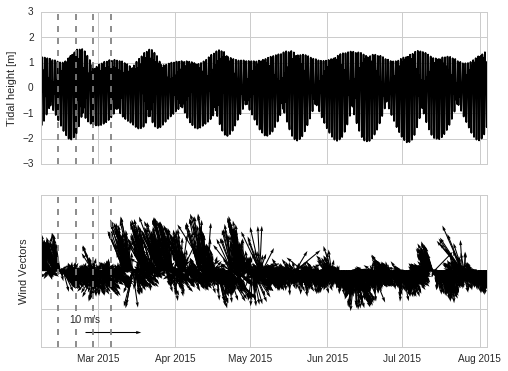

In [14]:
sns.set_style('whitegrid')
fig, axs = plt.subplots(2,1, figsize=(8, 6), sharex=True)
level = 0

tidetime,tideAll=plot_tides(axs[0], start, end, times, ts_lines)
winddatenum, wind, direc, us, vs=plot_winds(axs[1], 'East', OPlon, OPlat, start, end,times, ts_lines)


In [15]:

saveloc='/ocean/eolson/MEOPAR/analysis-elise/notebooks/plotResults/fullDomain398x898/exploreNowcast/NorthernNitrate/Movie/'
np.savez(saveloc+'saveTideWindCampbellR.npz',tidetime=tidetime,tideAll=tideAll,winddatenum=winddatenum, 
         wind=wind, direc=direc, us=us, vs=vs)